# Computer Vision 2025-2026 - NOVA FCT

### Assignment 1

**Authors**:
   - Luca Davì 75214 l.davi@campus.fct.unl.pt
   - Marta Negri 75169 m.negri@campus.fct.unl.pt


### Introduction

This project focuses on the development and analysis of an image matching algorithm that includes image preparation, keypoint detection, feature description, and comparison between different methods.  
Beyond simple feature matching, we implemented a complete image processing pipeline: from preprocessing and white balancing to detecting and describing keypoints, and finally comparing the results obtained with **SIFT** and our custom **MOPS** implementation.

In this report, we present a **simplified version** of our algorithm.  
Instead of processing all the images from the **input** folder, we demonstrate the procedure using **two similar images and one different image**.  
This approach makes it easier to visualize and understand each step of the algorithm while clearly showing the differences in performance and behavior between the two methods.




### Preparing the Images (Simplified Demonstration)

In this step, the selected images are resized while maintaining their **aspect ratio**.  
The **smaller side** of each image must be **512 pixels**.  
The resized images are then saved in the **output** folder.

For each image, the code:

* Loads it with OpenCV (`cv.imread`);
* Extracts its original dimensions (**height** and **width**);
* Computes a **scaling factor** so that the smaller side becomes 512 pixels, preserving the aspect ratio;
* Calculates the new width and height based on this scaling factor;
* Resizes the image using `cv.resize` with the interpolation method `INTER_AREA`, which provides good results when downscaling;
* Saves the resized image in the output directory, keeping the same filename.

This step prepares the images for the following steps such as color histogram computation and feature extraction.




c:\Users\utente\OneDrive\Desktop\AssigmentVisComp\VisComp2025\starter_code\75169_75214
Resized image: ../input/106200.jpg, New size: (682, 512)


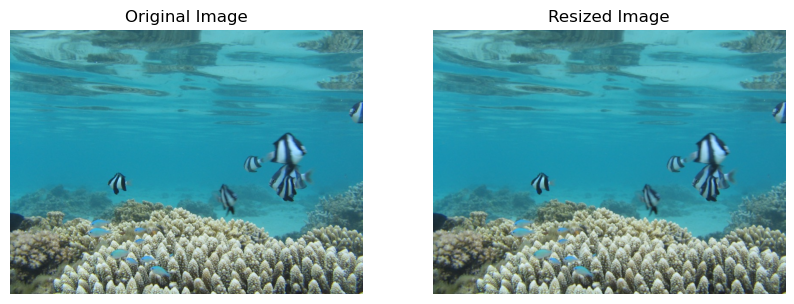

Resized image: ../input/106201.jpg, New size: (682, 512)


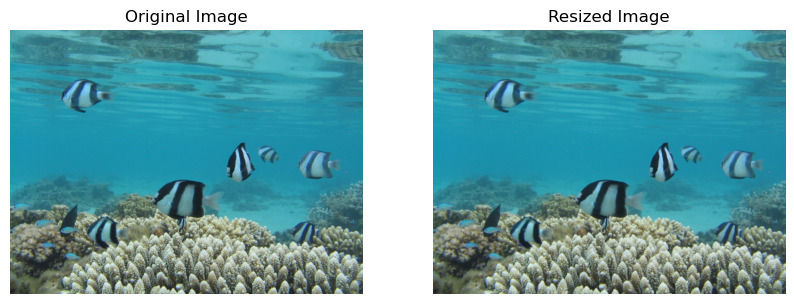

Resized image: ../input/100002.jpg, New size: (682, 512)


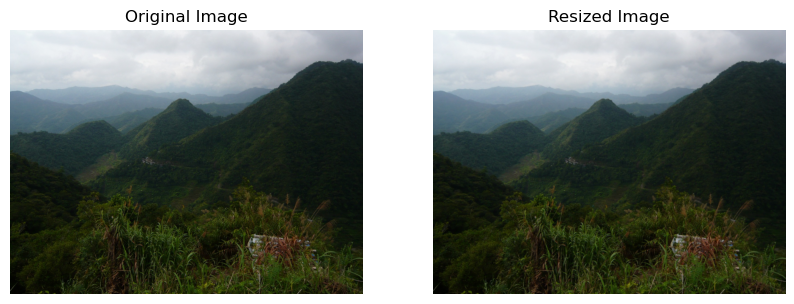

In [1]:
import cv2 as cv
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import json

# Resize a single image (no file is saved). The smaller side becomes `size`.
def resize_single_image_no_save(image_path, size=512):
    # Load image
    img = cv.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")

    # Get original dimensions
    h, w = img.shape[:2]

    # Calculate the scaling factor to maintain aspect ratio
    if h < w:
        scale = size / h
    else:
        scale = size / w

    # Calculate new dimensions
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Resize the image
    img_resized = cv.resize(img, (new_w, new_h), interpolation=cv.INTER_AREA)

    # Return the resized image (BGR) and its new size; nothing is saved to disk
    return img_resized, (new_w, new_h)


#let's use the function on 3 images:
image_paths = [
    '../input/106200.jpg',
    '../input/106201.jpg',
    '../input/100002.jpg'
]
print(os.getcwd())
for image_path in image_paths:
    resized_img, new_size = resize_single_image_no_save(image_path, size=512)
    print(f"Resized image: {image_path}, New size: {new_size}")

#show the images both original and resized
    original_img = cv.imread(image_path)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv.cvtColor(original_img, cv.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Resized Image")
    plt.imshow(cv.cvtColor(resized_img, cv.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

### Finding Similar Images

In this step, each image in the dataset is analyzed based on its **color distribution**, represented by the **RGB histograms** of the pixel intensities.  
The goal is to compare images using a similarity metric (either **Chi-Square** or **Bhattacharyya distance**) and group them into folders named `similar-0`, `similar-1`, etc., depending on how close their color histograms are.
In this report, instead of saving the three analyzed images into different folders, we will simply indicate which ones are similar or not, using basically the same algorithm as in the main project.

The process involves several functions:

* **`create_histogram(img_rgb_path)`**  
  Reads an image, converts it from BGR to RGB, splits it into its three channels, and computes a **256-bin histogram** for each (Red, Green, Blue).  
  The histograms are **normalized** to compensate for differences in image exposure, and then saved as a JSON file in a subfolder called `histograms`. In the original project follows a step where after an interation over all imput images,an histogram for each image is saved as json.

* **`histogram_distance(histA, histB)`**  
  Computes the **Chi-Square distance** between two histograms.  
  This measures how different the two images are in terms of color distribution: smaller values indicate more similar images.

* **`bhattacharyya_distance(histA, histB)`**  
  Implements an alternative distance measure using the **Bhattacharyya coefficient**, which quantifies the amount of overlap between two histograms.  
  Like the Chi-Square method, smaller distances correspond to higher similarity.

* **`plot_histogram(hist, title)`**  
  Displays the RGB histograms of an image using Matplotlib.

* **`group_by_similarity(input_dir, threshold)`**  
  In the project this function automatically groups images into subfolders based on the chosen distance metric (we used Chi-Squared).  
  Starting from the first image as a reference, each subsequent image is compared to it:
  - If the distance is **below the threshold**, it is considered similar and placed in the same folder.
  - If the distance is **above the threshold**, a new folder is created, and the current image becomes the new reference.  
  This logic simulates a chronological image sequence, as mentioned in the assignment.
  However in this simplified version, we just maually enstablished which images can be considered similar, both with Chi-Squared and Bhattacharyya distance with a 0.05 treshold.

At the end of this step, the dataset is divided into several *“similar groups”* ready for further analysis.

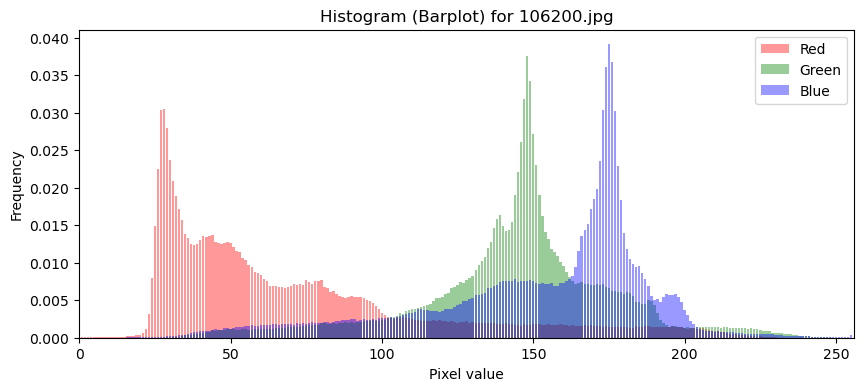

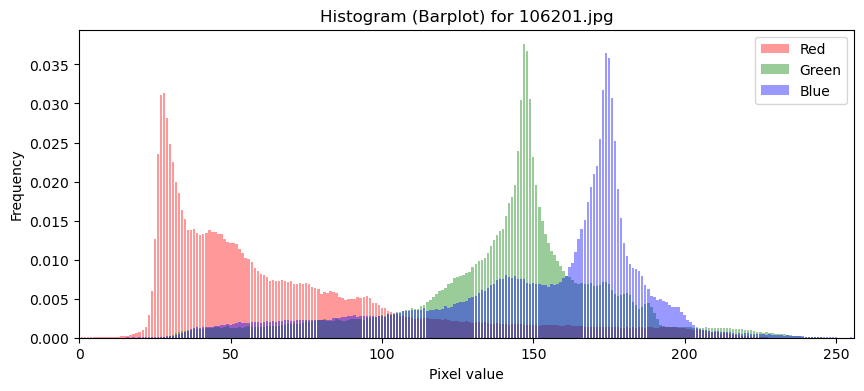

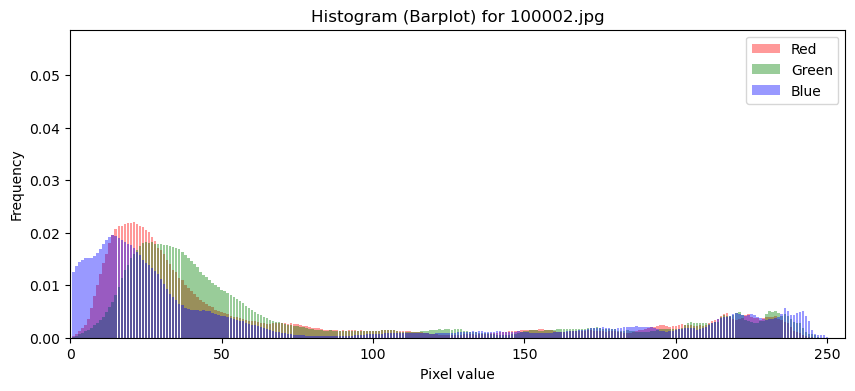


Pairwise distances (Chi-Square and Bhattacharyya):

106200.jpg vs 106201.jpg
  Chi-Square distance:      0.008541
  Bhattacharyya distance:   0.045845

106200.jpg vs 100002.jpg
  Chi-Square distance:      1.040522
  Bhattacharyya distance:   0.611422

106201.jpg vs 100002.jpg
  Chi-Square distance:      1.023457
  Bhattacharyya distance:   0.603290

Similarity results (based on Bhattacharyya distance < 0.5):

106200.jpg vs 106201.jpg → SIMILAR
106200.jpg vs 100002.jpg → DIFFERENT
106201.jpg vs 100002.jpg → DIFFERENT

Similarity results (based on Chi-Square distance < 0.6):

106200.jpg vs 106201.jpg → SIMILAR
106200.jpg vs 100002.jpg → DIFFERENT
106201.jpg vs 100002.jpg → DIFFERENT


In [7]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# List of the 3 images to test
image_paths = [
    '../input/106200.jpg',
    '../input/106201.jpg',
    '../input/100002.jpg'
]

# Compute histogram for a single image (no saving)
def create_histogram(img_rgb_path):
    # Load and convert BGR → RGB
    img_rgb = cv.imread(img_rgb_path)
    img_rgb = cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB)

    # Split channels
    R, G, B = img_rgb[:,:,0], img_rgb[:,:,1], img_rgb[:,:,2]

    # Compute histograms (256 bins each)
    hist_r = np.bincount(R.ravel(), minlength=256)
    hist_g = np.bincount(G.ravel(), minlength=256)
    hist_b = np.bincount(B.ravel(), minlength=256)

    # Normalize histograms (to handle brightness/exposure differences)
    hist_r = hist_r.astype(np.float32); hist_r /= hist_r.sum()
    hist_g = hist_g.astype(np.float32); hist_g /= hist_g.sum()
    hist_b = hist_b.astype(np.float32); hist_b /= hist_b.sum()

    return np.array([hist_r, hist_g, hist_b], dtype=np.float32)

# Plot RGB histograms as barplots
def plot_histogram(hist, title):
    bins = np.arange(256)
    plt.figure(figsize=(10,4))
    plt.title(title)
    plt.xlabel("Pixel value")
    plt.ylabel("Frequency")
    plt.xlim([0, 256])
    plt.bar(bins, hist[0], color='r', alpha=0.4, label='Red')
    plt.bar(bins, hist[1], color='g', alpha=0.4, label='Green')
    plt.bar(bins, hist[2], color='b', alpha=0.4, label='Blue')
    plt.legend()
    plt.show()

# Chi-Square distance
def histogram_distance(histA, histB):
    epsilon = 1e-10
    chi_sq_r = np.sum(((histA[0]-histB[0])**2) / (histA[0]+histB[0]+epsilon))
    chi_sq_g = np.sum(((histA[1]-histB[1])**2) / (histA[1]+histB[1]+epsilon))
    chi_sq_b = np.sum(((histA[2]-histB[2])**2) / (histA[2]+histB[2]+epsilon))
    return np.mean([chi_sq_r, chi_sq_g, chi_sq_b])

# Bhattacharyya distance
def bhattacharyya_distance(histA, histB):
    dist_r = cv.compareHist(histA[0].astype(np.float32), histB[0].astype(np.float32), cv.HISTCMP_BHATTACHARYYA)
    dist_g = cv.compareHist(histA[1].astype(np.float32), histB[1].astype(np.float32), cv.HISTCMP_BHATTACHARYYA)
    dist_b = cv.compareHist(histA[2].astype(np.float32), histB[2].astype(np.float32), cv.HISTCMP_BHATTACHARYYA)
    return np.mean([dist_r, dist_g, dist_b])

#MAIN TEST

# Compute histograms for the three images
hists = [create_histogram(p) for p in image_paths]

# Show histograms as barplots
for i, p in enumerate(image_paths):
    plot_histogram(hists[i], f"Histogram (Barplot) for {p.split('/')[-1]}")

# Compute distances pairwise
print("\nPairwise distances (Chi-Square and Bhattacharyya):\n")
for i in range(len(hists)):
    for j in range(i+1, len(hists)):
        chi = histogram_distance(hists[i], hists[j])
        bha = bhattacharyya_distance(hists[i], hists[j])
        print(f"{image_paths[i].split('/')[-1]} vs {image_paths[j].split('/')[-1]}")
        print(f"  Chi-Square distance:      {chi:.6f}")
        print(f"  Bhattacharyya distance:   {bha:.6f}\n")

# Define a simple similarity threshold
threshold_bha = 0.5      # for Bhattacharyya
threshold_chi = 0.6      # for Chi-Square
print("Similarity results (based on Bhattacharyya distance < 0.5):\n")
for i in range(len(hists)):
    for j in range(i+1, len(hists)):
        bha = bhattacharyya_distance(hists[i], hists[j])
        relation = "SIMILAR" if bha < threshold_bha else "DIFFERENT"
        print(f"{image_paths[i].split('/')[-1]} vs {image_paths[j].split('/')[-1]} → {relation}")

print("\nSimilarity results (based on Chi-Square distance < 0.6):\n")
for i in range(len(hists)):
    for j in range(i+1, len(hists)):
        chi = histogram_distance(hists[i], hists[j])
        relation = "SIMILAR" if chi < threshold_chi else "DIFFERENT"
        print(f"{image_paths[i].split('/')[-1]} vs {image_paths[j].split('/')[-1]} → {relation}")


### Compute Common Histogram and Equalize White Balance

After grouping the images, each *similar-* folder is processed to compute an **average (common) histogram** and perform a **white balance correction**. In our example we will just consider images 106200.jpg and 106201.jpg as similar, since the last step proved just that.We will then create a common histogram and operate white balance with these two.
However the complese algorithm over the etire input folder works as follows:

* **`common_histogram_and_white_balance(input_dir)`**  
  This function iterates through each `similar-*` folder and performs the following steps:
  1. **Compute the average histogram:**  
     Loads all the histograms of the images in the folder (previously saved as JSON), sums them, and divides by the number of images to get a mean histogram representing the group.
  2. **Save the common histogram:**  
     Stores it in the folder as `common_histogram.json`.
  3. **Apply white balance correction:**  
     For each image, the mean intensity of each color channel (R, G, B) is computed from the common histogram.  
     The algorithm adjusts each channel so that their average intensity matches the global grey value:
     \[
     \text{img\_wb}(c) = \text{img}(c) \times \frac{\text{avg\_grey}}{\text{avg\_rgb}[c]}
     \]
     This step compensates for color casts (e.g., too warm or too cool tones) and normalizes illumination differences between images.
  4. **Save results:**  
     Each corrected image is saved in the same folder, prefixed with `wb_`.

The output of this phase consists of:
- A file `common_histogram.json` summarizing the average color distribution of the group;
- A set of **white-balanced images** (`wb_*.jpg`), ready for descriptor extraction and comparison in the next steps.

In our example we will just output the common histogram for the two similar images and the images after the white balance step.


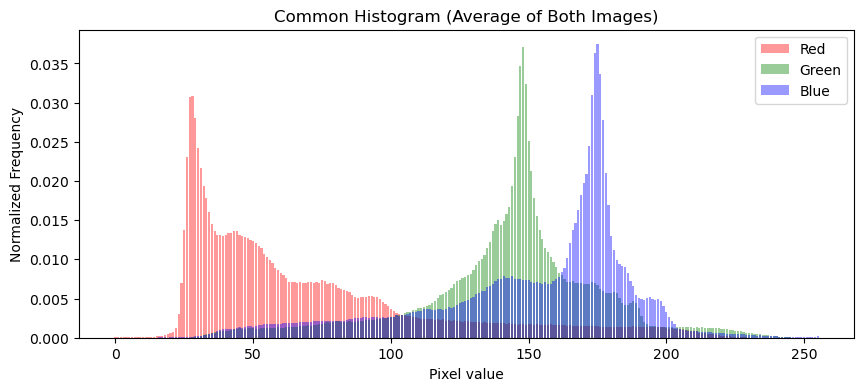

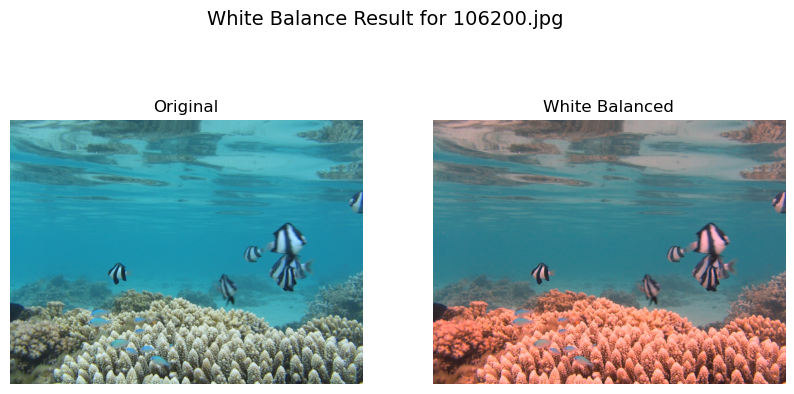

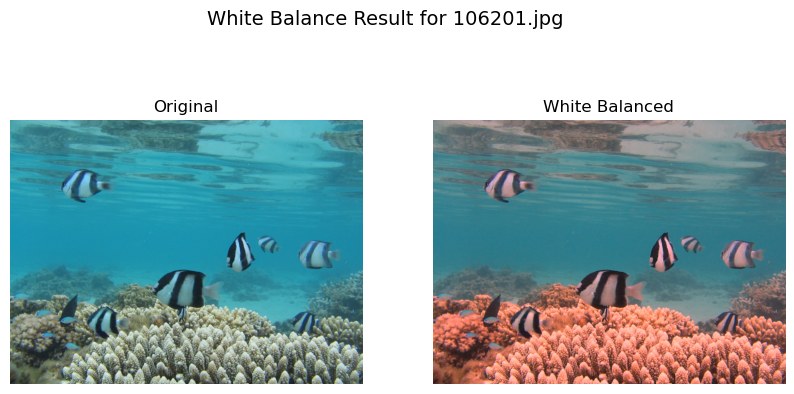

In [ ]:
# Paths of the two similar images
similar_image_paths = [
    '../input/106200.jpg',
    '../input/106201.jpg'
]

def common_histogram_and_white_balance_two_images(image_paths):
    if len(image_paths) < 2:
        print("Need at least two images to compute a common histogram.")
        return

    # Compute the common histogram
    common_hist = np.zeros((3, 256), dtype=np.float32)

    for img_path in image_paths:
        # Load and convert to RGB
        img = cv.imread(img_path)
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        # Compute per-channel histograms (normalized)
        R, G, B = img_rgb[:,:,0], img_rgb[:,:,1], img_rgb[:,:,2]
        hist_r = np.bincount(R.ravel(), minlength=256).astype(np.float32)
        hist_g = np.bincount(G.ravel(), minlength=256).astype(np.float32)
        hist_b = np.bincount(B.ravel(), minlength=256).astype(np.float32)

        hist_r /= hist_r.sum()
        hist_g /= hist_g.sum()
        hist_b /= hist_b.sum()

        hist = np.array([hist_r, hist_g, hist_b], dtype=np.float32)
        common_hist += hist

    common_hist /= len(image_paths)  # Average histogram across both images

    # Plot the common histogram
    bins = np.arange(256)
    plt.figure(figsize=(10,4))
    plt.title("Common Histogram (Average of Both Images)")
    plt.xlabel("Pixel value")
    plt.ylabel("Normalized Frequency")
    plt.bar(bins, common_hist[0], color='r', alpha=0.4, label='Red')
    plt.bar(bins, common_hist[1], color='g', alpha=0.4, label='Green')
    plt.bar(bins, common_hist[2], color='b', alpha=0.4, label='Blue')
    plt.legend()
    plt.show()

    # Compute average intensity per channel
    avg_rgb = np.zeros(3, dtype=np.float32)
    for c in range(3):
        avg_rgb[c] = np.sum(np.arange(256) * common_hist[c]) / np.sum(common_hist[c])
    avg_grey = np.mean(avg_rgb)

    # Apply white balance to each image
    wb_images = []
    for img_path in image_paths:
        img = cv.imread(img_path)
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        img_wb = img_rgb.astype(np.float32)
        for c in range(3):
            img_wb[:,:,c] = img_wb[:,:,c] * (avg_grey / avg_rgb[c])

        img_wb = np.clip(img_wb, 0, 255).astype(np.uint8)
        wb_images.append(img_wb)


    #Save the white-balanced images in a variable
    balanced_images = wb_images
    balanced_img1, balanced_img2 = balanced_images[0], balanced_images[1]

    # Show original and white-balanced images side by side
    for i, img_path in enumerate(image_paths):
        orig = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)
        wb = wb_images[i]

        plt.figure(figsize=(10,5))
        plt.suptitle(f"White Balance Result for {img_path.split('/')[-1]}", fontsize=14)
        plt.subplot(1,2,1)
        plt.imshow(orig)
        plt.title("Original")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(wb)
        plt.title("White Balanced")
        plt.axis('off')
        plt.show()

    # Optionally return them if needed elsewhere
    return balanced_images



balanced_images = common_histogram_and_white_balance_two_images(similar_image_paths)
balanced_img1, balanced_img2 = balanced_images[0], balanced_images[1]


### Create your own descriptor based on MOPS 
In this step, we implemented a simplified version of the **MOPS (Multi-scale Oriented Patches)** algorithm, structured in several key steps: **feature detection**, **orientation estimation**, **descriptor creation**, and **feature matching**.  

#### 1. Point Detection — function `my_track_points()`

To identify salient points in each image, we used the function `cv2.goodFeaturesToTrack`, based on the **Shi-Tomasi corner detector**.  
Before feature detection, the image is converted to grayscale to ensure consistent processing.

**Chosen parameters:**
- `maxCorners = 300` → limits the number of strongest corners to 300, ensuring a good balance between robustness and computation time.  
- `qualityLevel = 0.01` → filters out weak corners based on a 1% threshold of the maximum corner quality.  
- `minDistance = 10` → prevents keypoints from being too close together, avoiding redundant detections.  

These settings provide a good compromise between detecting enough points for reliable matching while minimizing noisy or overlapping features. This combination of parameters was found to be ideal after some experimentation.

#### 2. Orientation Estimation — function `my_point_rotation()`

For each detected point, a square patch centered on the feature is extracted using `cv2.getRectSubPix`.  
Then, **Sobel filters** (`cv2.Sobel`) are applied to compute image gradients in both x and y directions.  
The gradient orientations are accumulated into a **36-bin histogram** over the range \([-π, π]\), and the **dominant angle** (the most frequent orientation) is selected.

**Chosen parameter:**
- `window_size = 40` → defines the local area around each point used to compute gradients. A 40×40 patch provides enough local context without including too much irrelevant background.

This step provides **rotation invariance**, ensuring that the descriptors remain consistent even when the image is rotated.

#### 3. Descriptor Construction — function `my_descriptor()`

Each point is described by a **normalized and rotated local patch**, following these steps:

1. Extract a 40 x 40 window centered on the keypoint.  
2. Rotate the patch by its dominant orientation using `cv2.getRotationMatrix2D` and `cv2.warpAffine`.  
3. **Downsample** the rotated region to an 8 x 8 grid to form a compact descriptor.  
4. **Normalize** the descriptor between 0 and 1 to reduce the effects of illumination changes.

The resulting descriptor is a **flattened 64-dimensional vector**, representing the local texture pattern around the feature.

#### 4. Feature Matching — `my_distance()` and `my_match()`

Feature comparison is performed using the **Euclidean distance** as a similarity measure between descriptors.

The matching algorithm implements the **Nearest Neighbour Ratio Test**:
- For each descriptor in Image 1, find the two nearest descriptors in Image 2.  
- A match is accepted only if the distance to the best match is significantly smaller than the distance to the second-best match with `ratio_threshold = 0.7`.

This ratio threshold was chosen to reduce false positives and ensure higher matching precision, even at the cost of fewer matches.

#### 5. Visualization — `my_draw_matches()`

This function combines all previous steps:
- Detect points in both images  
- Compute their orientations and descriptors  
- Match the descriptors using the ratio test  
- Draw visual correspondences using `cv2.drawMatches`

The output image displays **lines connecting matched features** across the two input images, allowing a qualitative evaluation of the algorithm’s performance.


Number of matches found: 173


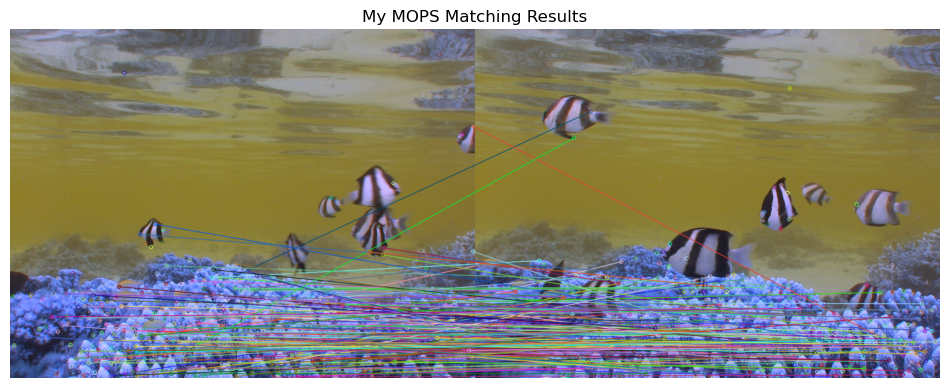

In [32]:
import cv2 as cv
import numpy as np


class myMOPS:
    def __init__(self):
        pass
    def _to_gray(self, img) -> cv.typing.MatLike:
        """ Convert image to grayscale if it is not already."""
        if len(img.shape) == 3:
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        return img.astype(np.float32)
    def my_track_points(self, img, maxCorners, qualityLevel, minDistance) -> cv.typing.MatLike:
        """ Function that find points using cv2.goodFeaturesToTrack . """
        img = self._to_gray(img)

        points = cv.goodFeaturesToTrack(img, mask=None, maxCorners=maxCorners, qualityLevel=qualityLevel, minDistance=minDistance)

        return points.reshape(-1, 2)
    def my_point_rotation(self, img, point, window_size) -> float:
        """ Function that given a point and an area around the point finds its rotation"""
        # extract window using cv.getRectSubPix, which interpolates border pixels
        img = self._to_gray(img)
        x,y = float(point[0]), float(point[1])
        img_window = cv.getRectSubPix(img, (window_size, window_size), (x, y))
        # Compute gradients

        sobelx = cv.Sobel(img_window, ddepth=cv.CV_32F, dx=1, dy=0, ksize=3)
        sobely = cv.Sobel(img_window, ddepth=cv.CV_32F, dx=0, dy=1, ksize=3)

        #compute angle histogram
        angles = np.arctan2(sobely, sobelx)
        magnitudes = np.sqrt(sobelx**2 + sobely**2)
        hist, bin_edges = np.histogram(angles.ravel(), bins=36, range=(-np.pi, np.pi),weights=magnitudes.ravel())
        
        best_idx = np.argmax(hist)
        dominant_angle = 0.5*(bin_edges[best_idx] + bin_edges[best_idx+1]) #center of the bin 
        return dominant_angle
    def my_descriptor(self, img, point, dominant_angle, window_size=40) -> np.ndarray:
        """ Function that creates your own descriptor for each point."""
        img = self._to_gray(img)
        x,y = float(point[0]), float(point[1])
        img_window = cv.getRectSubPix(img, (window_size, window_size), (x, y))

        # Rotate the window to align with dominant angle
        center = (window_size / 2, window_size / 2)
        rotation_matrix = cv.getRotationMatrix2D(center, np.degrees(-dominant_angle), scale=1.0/5.0)
        rotated_window = cv.warpAffine(img_window, rotation_matrix, (window_size, window_size), flags=cv.INTER_LINEAR)

        # Downsample to 8x8
        small_window = cv.resize(rotated_window, (8, 8), interpolation=cv.INTER_AREA)

        # Normalize between 0 and 1
        descriptor = small_window.flatten()
        descriptor = (descriptor - np.min(descriptor)) / (np.max(descriptor) - np.min(descriptor) + 1e-10)  # add small value to avoid division by zero
        return descriptor
    def my_distance(self, desc1, desc2) -> float:
        """ Create a function that given two descriptors gives a match distance score using the Euclidean Distance."""
        return np.linalg.norm(desc1 - desc2)
    def my_match(self, D1, D2, ratio_threshold) -> bool:
        """ Create a function that gives a match based on the Nearest Neighbours ratio and a certain Threshold.
            D1: list of descriptors from image 1
            D2: list of descriptors from image 2
            ratio_threshold: threshold for the ratio test
            Returns: list of matches
        """

        matches = []
        for i, desc1 in enumerate(D1):
            # Find the two closest descriptors in D2
            distances = [self.my_distance(desc1, desc2) for desc2 in D2]
            best_match = np.argmin(distances)
            best_match_distance = distances[best_match]
            dist_copy= distances.copy()
            dist_copy[best_match]=np.inf #remove best match by setting to small number
            
            second_best = np.argmin(dist_copy)
            second_best_distance = distances[second_best]
            if best_match_distance < ratio_threshold * second_best_distance:
                matches.append(cv.DMatch(_queryIdx=i, _trainIdx=best_match, _distance=best_match_distance))
        return matches

    def _points_to_keypoints(self, points) -> list:
        """ Convert points to cv2.KeyPoint objects."""
        keypoints = [cv.KeyPoint(x=float(p[0]), y=float(p[1]), size=3) for p in points]
        return keypoints
    def my_draw_matches(self,img1, img2) -> np.ndarray:
        """ Output an image comparison ("my_match.jpg") in the output directory using your algorithm and using SIFT."""
        # Find points
        points1 = self.my_track_points(img1, maxCorners=500, qualityLevel=0.01, minDistance=10)
        points2 = self.my_track_points(img2, maxCorners=500, qualityLevel=0.01, minDistance=10)

        # Compute descriptors
        descriptors1 = []
        for p in points1:
            angle = self.my_point_rotation(img1, p, window_size=40)
            desc = self.my_descriptor(img1, p, angle)
            descriptors1.append(desc)
        descriptors2 = []
        for p in points2:
            angle = self.my_point_rotation(img2, p, window_size=40)
            desc = self.my_descriptor(img2, p, angle)
            descriptors2.append(desc)

        # Match descriptors
        matches = self.my_match(descriptors1.copy(), descriptors2.copy(), ratio_threshold=0.7)
        # Convert points to keypoints
        keypoints1 = self._points_to_keypoints(points1)
        keypoints2 = self._points_to_keypoints(points2)

        # Draw matches
        print(f"Number of matches found: {len(matches)}")
        matched_image = cv.drawMatches(img1, keypoints1, img2, keypoints2, matches, None)
        return matched_image
    
#  TESTING myMOPS with the two white-balanced images

# Instantiate the class
mops = myMOPS()

# Run the matching algorithm on your balanced images
matched_img = mops.my_draw_matches(balanced_img1, balanced_img2)

# Save and display the result
cv.imwrite("my_match.jpg", matched_img)

# If you're in a Jupyter Notebook, you can also display it directly:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("My MOPS Matching Results")
plt.show()

    

### 7. Compare all images and print stats

This section aims to compare all images, check for similarities, and compute matching statistics. In the original project, this also included comparing the results with a ground truth set.  
However, since this report focuses on only two images, it was not possible to perform the full analysis.

Instead, we compared the two images using the **SIFT (Scale-Invariant Feature Transform)** descriptor to:

* detect the main **keypoints** in both images;  
* compute the **matches** between their descriptors;  
* visualize the **correspondences** by drawing lines connecting similar regions.

This allows a direct visual comparison between **SIFT** and our **MOPS** method.  
To ensure fairness, the number of detected features was limited to the **500 strongest corners** per image.




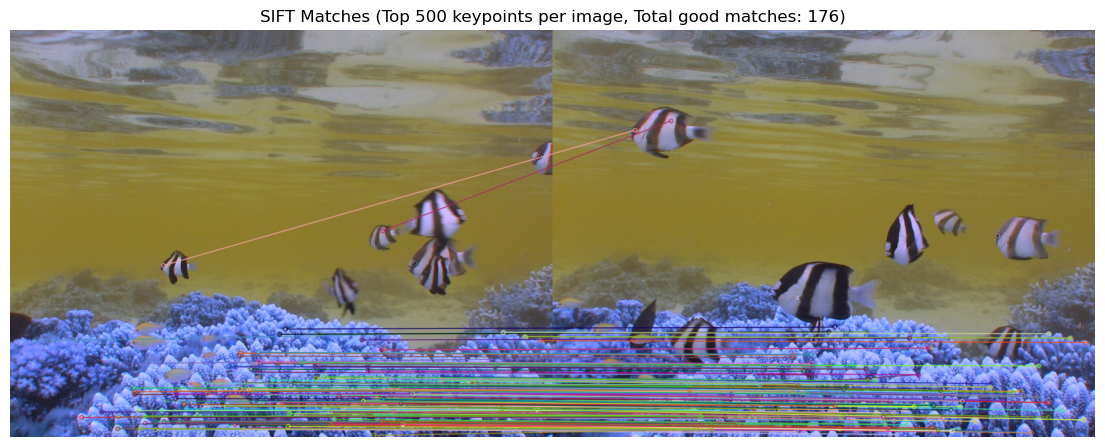

to ensure visual comparability ith mops we reduced the number of SIFT keypoints to 500 per image:
SIFT keypoints in image 1: 500
SIFT keypoints in image 2: 500

Total good matches after ratio test: 176


In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# SIFT MATCHING (COMPARABLE TO MOPS)

# Load the white-balanced images
# Assuming these two variables already exist: balanced_img1, balanced_img2

# Apply SIFT on the same white-balanced images as MOPS
sift = cv.SIFT_create()

# Detect all keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(balanced_img1, None)
kp2, des2 = sift.detectAndCompute(balanced_img2, None)

# Keep the top 500 strongest keypoints per image
# This ensures the feature density and visualization are comparable to MOPS
kp1 = sorted(kp1, key=lambda x: -x.response)[:500]
kp2 = sorted(kp2, key=lambda x: -x.response)[:500]

# Recompute descriptors for the selected strongest keypoints
des1 = sift.compute(balanced_img1, kp1)[1]
des2 = sift.compute(balanced_img2, kp2)[1]

# Use FLANN-based matcher for descriptor comparison
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe’s ratio test using the same threshold as in MOPS (0.7)
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Visualization of SIFT matches
# The same flags are used as in MOPS to ensure visual comparability
matched_sift = cv.drawMatches(
    balanced_img1, kp1, balanced_img2, kp2, good_matches, None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Save and display the SIFT match visualization
cv.imwrite("sift_matches_500kp.jpg", matched_sift)

plt.figure(figsize=(14, 7)) 
plt.imshow(cv.cvtColor(matched_sift, cv.COLOR_BGR2RGB))
plt.title(f"SIFT Matches (Top 500 keypoints per image, Total good matches: {len(good_matches)})")
plt.axis("off")
plt.show()

# Print summary results for console output
print("to ensure visual comparability ith mops we reduced the number of SIFT keypoints to 500 per image:")
print(f"SIFT keypoints in image 1: {len(kp1)}")
print(f"SIFT keypoints in image 2: {len(kp2)}\n")
print(f"Total good matches after ratio test: {len(good_matches)}")



### Conclusion

Since histogram-based matching relies on global intensity distributions rather than local feature information, even a small error with respect to the ground truth can cause a **cascade effect**: if the query image is matched to the wrong folder, the next folder in the sequence is automatically misclassified, resulting in a precision of zero for that case.  
This explains the poor results obtained in the statistical comparison and highlights the critical weaknesses of this type of matching approach.

From our experiments, it is clear that the **MOPS** implementation is visually much less precise than **SIFT**.
WRITE ABOUT WHAT IS MAKING THE METHODS DIFFERENT.  

Additionally, when comparing different distance metrics for histogram comparison, the results showed that using the **Chi-squared** distance instead of the **Bhattacharyya** distance produces only minimal differences, making the choice between them largely irrelevant for this task. WRITE ABOUT THE FACTS THAT THE TRESHOLD CHABGE BECAUS CHI 0 - INFINITO B 0-1

